In [1]:
from utils import *
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
from scipy.spatial import distance 
import itertools

In [2]:
TASK = 'nback'

In [3]:
def sim_nback_context(set_size,delta=1,
      nitr=1,metric='cosine',cvar=.1,cmean=.1,cdim=20,verb=False):  
  """
  - generate multiple draws from context sequence
  - calculate distance between reference context and
  - (i)  target context    (nback)
  - (ii) nontarget context (nback+-k)
  return array of distances (i) & (ii)
  """
  exp_size = 25
  current_t = exp_size - 1
  target_t = current_t - set_size
  nontarget_t = target_t+delta
  if verb: print('ss',set_size,'current_t',current_t,
            'target',target_t,'nontarget',nontarget_t)

  # loop vars
  dist2targetL = []
  dist2nontargetL = []
  for itr in range(nitr):
    # sample new context
    C = fast_n_sphere(n_steps=exp_size, dim=cdim, var=cvar, mean=cmean)[0]
    # target distance
    dist2target_    = distance.cdist(
      [C[current_t,:]],[C[target_t,:]],
      metric=metric)[0]
    # nontarget distance
    dist2nontarget_ = distance.cdist(
      [C[current_t,:]],[C[nontarget_t,:]],
      metric=metric)[0]
    # collect
    dist2targetL.append(dist2target_)
    dist2nontargetL.append(dist2nontarget_)
    
  dist2target = np.concatenate(dist2targetL)
  dist2nontarget = np.concatenate(dist2nontargetL)
  return dist2target,dist2nontarget


In [4]:
def compute_roc(dist2target,dist2nontarget):
  # ranges
  lower = np.min([dist2target.min(),dist2nontarget.min()]) 
  upper = np.max([dist2target.max(),dist2nontarget.max()])
  # histograms
  hist_target,_ = np.histogram(dist2target,range=(lower,upper),bins=100)
  hist_nontarget,_ = np.histogram(dist2nontarget,range=(lower,upper),bins=100)
  # roc
  roc_x = np.cumsum(hist_target/hist_target.sum())
  roc_y = np.cumsum(hist_nontarget/hist_nontarget.sum())
  return roc_x,roc_y

def plt_auc_analyis(M,N,K,ssL=np.arange(1,6)):
  
  plt.figure(figsize=(16,6))
  ax = plt.gca()
  for ss in ssL:
    dist2target,dist2nontarget = sim_nback_context(ss,delta=1,
        nitr=1000,metric='cosine',cvar=N,cmean=M,cdim=K,verb=False)
    roc_x,roc_y = compute_roc(dist2target,dist2nontarget)
    auc = roc_y.sum()
    ax.bar(ss,auc,color='purple')
  ax.set_xlabel('set size')
  ax.set_ylabel('AUC')
  plt.savefig('figures/nback/rocauc-K{}M{}N{}.png'.format(K,M,N))
  return None


In [5]:
def plt_roc(ax,dist2target,dist2nontarget,label,idx=0):
  """ confirm that this is an ROC
  assuming that distance is the signal for detecting "match"
  """
  cL = ['r','g']
  rocx,rocy = compute_roc(dist2target,dist2nontarget)
  ax.plot(rocx,rocy,label=label,color=cL[idx])
  ax.plot([0,1],[0,1],c='k',ls='--')
  return None

In [6]:
def runexp_and_plt(M,N,K,ssL=[2,3],nitr=20000,sim_fn=sim_nback_context):
  """ 
  given parametrization of context
  runs 'dprime experiment' and generates plots
  """
  f,axarr = plt.subplots(1,3,figsize=(20,6))
  overlapL = []
  for idx,ss in enumerate(ssL):
    # run simulations
    dist2target,dist2nontarget = sim_fn(
      set_size=ss,
      nitr=nitr,
      cvar=N,cmean=M,cdim=K
    ) 
    # plot histogtams
    ax = axarr[idx]
    ax.set_title("set-size=%i"%ss)
    hist_target = ax.hist(dist2target,bins=100,label='target')[0]
    hist_nontarget = ax.hist(dist2nontarget,bins=100,label='nontarget')[0]
    # plt hist
    # NB flipped call fn for stern
    plt_roc(axarr[2],dist2target,dist2nontarget,"set-size=%i"%ss,idx)
  # calculate overlap difference
  plt.legend()
  ax.legend()
  fig_title = "K{}M{}N{}".format(K,M,N)
  plt.savefig('figures/nback/hist-%s.png'%fig_title)
  plt.close('all')
  return None

### gridsearch and plt

5 0.2 0.05

5 0.2 0.1

5 0.2 0.2

5 0.2 0.3

5 0.3 0.05

5 0.3 0.1

5 0.3 0.2

5 0.3 0.3

5 0.4 0.05

5 0.4 0.1

5 0.4 0.2

5 0.4 0.3

10 0.2 0.05

10 0.2 0.1

10 0.2 0.2

10 0.2 0.3

10 0.3 0.05

10 0.3 0.1

10 0.3 0.2

10 0.3 0.3

10 0.4 0.05

10 0.4 0.1

10 0.4 0.2

10 0.4 0.3

20 0.2 0.05

20 0.2 0.1

20 0.2 0.2

20 0.2 0.3

20 0.3 0.05

20 0.3 0.1

20 0.3 0.2

20 0.3 0.3

20 0.4 0.05

20 0.4 0.1

20 0.4 0.2

20 0.4 0.3

25 0.2 0.05

25 0.2 0.1

25 0.2 0.2

25 0.2 0.3

25 0.3 0.05

25 0.3 0.1

25 0.3 0.2

25 0.3 0.3

25 0.4 0.05

25 0.4 0.1

25 0.4 0.2

25 0.4 0.3



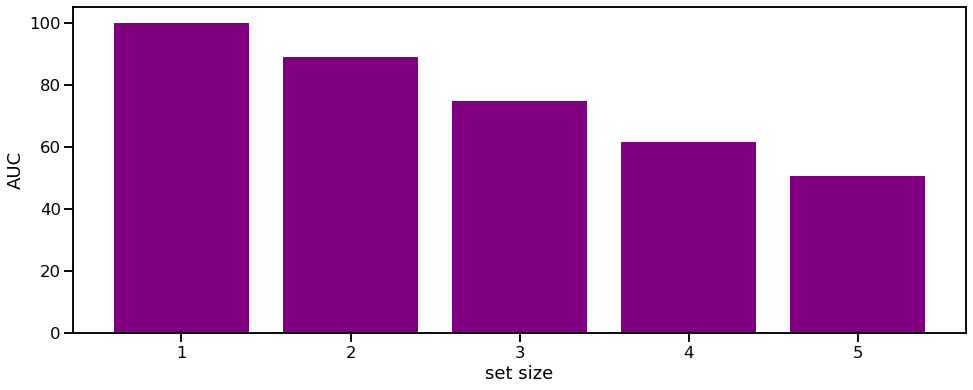

In [7]:
## gridsearch
ML = [0.2,0.3,0.4]
NL = [0.05,0.1,0.2,0.3]
KL = [5,10,20,25] 
for K,M,N in itertools.product(KL,ML,NL):
  print(K,M,N)
  runexp_and_plt(M,N,K,nitr=10000)
  plt_auc_analyis(M,N,K)
  print()